<a href="https://colab.research.google.com/github/Katerynashmat/Conc-/blob/main/cnn1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mask detection CNN training

In [39]:
# from google.colab import drive
# drive.mount('/content/drive')

In [106]:
# from distutils.dir_util import copy_tree
# copy_tree("/content/drive/MyDrive/data/mask1", "/content")
# copy_tree("/content/models", "/content/drive/MyDrive/data/")



['/content/drive/MyDrive/data/pic/m2.png',
 '/content/drive/MyDrive/data/pic/m0.png',
 '/content/drive/MyDrive/data/pic/m1.png']

In [41]:
import os

# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk("train"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 5 directories and 0 images in 'train'.
There are 0 directories and 850 images in 'train/Correct'.
There are 0 directories and 827 images in 'train/Without_Mask'.
There are 0 directories and 522 images in 'train/Mask_Nose_Mouth'.
There are 0 directories and 849 images in 'train/Mask_Mouth_Chin'.
There are 0 directories and 850 images in 'train/Mask_Chin'.


In [42]:
import os

# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk("test"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 5 directories and 0 images in 'test'.
There are 0 directories and 150 images in 'test/Correct'.
There are 0 directories and 139 images in 'test/Without_Mask'.
There are 0 directories and 93 images in 'test/Mask_Nose_Mouth'.
There are 0 directories and 150 images in 'test/Mask_Mouth_Chin'.
There are 0 directories and 150 images in 'test/Mask_Chin'.


In [43]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)
import pathlib
import numpy as np
data_dir = pathlib.Path("train/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['Correct' 'Mask_Chin' 'Mask_Mouth_Chin' 'Mask_Nose_Mouth' 'Without_Mask']


In [44]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (725, 725)


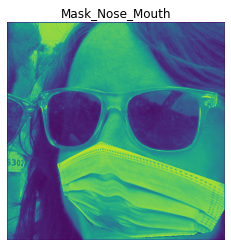

In [45]:
# View a random image from the training dataset
img = view_random_image(target_dir="train/",
                        target_class="Mask_Nose_Mouth")

In [46]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup the train and test directories
train_dir = "train/"
test_dir = "test/"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32, # number of images to process at a time 
                                               target_size=(224, 224), # convert all images to be 224 x 224
                                               class_mode="categorical", # type of problem we're working on
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="categorical",
                                               seed=42)

# Create a CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)


Found 3898 images belonging to 5 classes.
Found 682 images belonging to 5 classes.


In [47]:
model0 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10, 
                         kernel_size=3, # can also be (3, 3)
                         activation="relu", 
                         input_shape=(224, 224,3)), # first layer specifies input shape (height, width, colour channels)
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(5, activation="softmax") # activation output
])

# Compile the model
model0.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history0 = model0.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
122/122 [==============================] - 19s 152ms/step - loss: 0.5356 - accuracy: 0.8002 - val_loss: 0.2418 - val_accuracy: 0.9311
Epoch 2/5
122/122 [==============================] - 18s 150ms/step - loss: 0.0781 - accuracy: 0.9754 - val_loss: 0.1266 - val_accuracy: 0.9648
Epoch 3/5
122/122 [==============================] - 18s 150ms/step - loss: 0.0281 - accuracy: 0.9913 - val_loss: 0.1289 - val_accuracy: 0.9619
Epoch 4/5
122/122 [==============================] - 18s 151ms/step - loss: 0.0155 - accuracy: 0.9969 - val_loss: 0.1049 - val_accuracy: 0.9677
Epoch 5/5
122/122 [==============================] - 18s 150ms/step - loss: 0.0109 - accuracy: 0.9964 - val_loss: 0.1265 - val_accuracy: 0.9604


In [56]:
model0.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_5 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 110, 110, 10)     0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_7 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                  

In [74]:
model0.save("models/model0.h5")



## Transfer learning 1

In [49]:
len(class_names)

5

## ResNet

In [82]:
# Set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
# train_datagen = ImageDataGenerator(rescale=1./255)
# valid_datagen = ImageDataGenerator(rescale=1./255)

train_datagen = ImageDataGenerator()
valid_datagen = ImageDataGenerator()

# Setup the train and test directories
train_dir = "train/"
test_dir = "test/"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32, # number of images to process at a time 
                                               target_size=(224, 224), # convert all images to be 224 x 224
                                               class_mode="categorical", # type of problem we're working on
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="categorical",
                                               seed=42)

Found 3898 images belonging to 5 classes.
Found 682 images belonging to 5 classes.


In [83]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.ResNet50V2(include_top=False)

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x=inputs
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(class_names), activation="softmax", name="output_layer")(x) # same number of outputs as classes
model1 = tf.keras.Model(inputs, outputs)

In [84]:
# Compile
model1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history1 = model2.fit(train_data,
                                           epochs=5, # fit for 5 epochs to keep experiments quick
                                           validation_data=valid_data,
                                           validation_steps=int(len(valid_data)))

Epoch 1/5
122/122 [==============================] - 21s 165ms/step - loss: 0.0058 - accuracy: 0.9995 - val_loss: 0.0416 - val_accuracy: 0.9853
Epoch 2/5
122/122 [==============================] - 20s 160ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.0430 - val_accuracy: 0.9853
Epoch 3/5
122/122 [==============================] - 19s 159ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.0424 - val_accuracy: 0.9853
Epoch 4/5
122/122 [==============================] - 19s 159ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.0435 - val_accuracy: 0.9868
Epoch 5/5
122/122 [==============================] - 19s 159ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 0.0439 - val_accuracy: 0.9853


In [85]:
model1.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, None, None, 2048)  23564800  
                                                                 
 global_average_pooling (Glo  (None, 2048)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 5)                 10245     
                                                                 
Total params: 23,575,045
Trainable params: 23,529,605
Non-trainable params: 45,440
_________________________________________________________________


In [86]:
model1.save("models/model1.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [58]:
initial_epoch=5

base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile the model (always recompile after any adjustments to a model)
model1.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), # lr is 10x lower than before for fine-tuning
              metrics=["accuracy"])

In [59]:
history1ft=model1.fit(train_data,
            epochs=initial_epoch +5,
            validation_data=valid_data,
            initial_epoch=initial_epoch)

Epoch 6/10
122/122 [==============================] - 24s 178ms/step - loss: 0.0781 - accuracy: 0.9787 - val_loss: 0.0922 - val_accuracy: 0.9677
Epoch 7/10
122/122 [==============================] - 21s 170ms/step - loss: 0.0460 - accuracy: 0.9867 - val_loss: 0.0713 - val_accuracy: 0.9795
Epoch 8/10
122/122 [==============================] - 21s 171ms/step - loss: 0.0274 - accuracy: 0.9941 - val_loss: 0.0576 - val_accuracy: 0.9795
Epoch 9/10
122/122 [==============================] - 21s 172ms/step - loss: 0.0176 - accuracy: 0.9974 - val_loss: 0.0487 - val_accuracy: 0.9795
Epoch 10/10
122/122 [==============================] - 21s 172ms/step - loss: 0.0118 - accuracy: 0.9987 - val_loss: 0.0456 - val_accuracy: 0.9824


In [60]:
model1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, None, None, 2048)  23564800  
                                                                 
 global_average_pooling (Glo  (None, 2048)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 5)                 10245     
                                                                 
Total params: 23,575,045
Trainable params: 3,426,309
Non-trainable params: 20,148,736
_________________________________________________________________


In [61]:
model1.save("models/model1ft.h5")

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


## EfficientNet

In [62]:
# Set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
# train_datagen = ImageDataGenerator(rescale=1./255)
# valid_datagen = ImageDataGenerator(rescale=1./255)

train_datagen = ImageDataGenerator()
valid_datagen = ImageDataGenerator()

# Setup the train and test directories
train_dir = "train/"
test_dir = "test/"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=32, # number of images to process at a time 
                                               target_size=(224, 224), # convert all images to be 224 x 224
                                               class_mode="categorical", # type of problem we're working on
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=32,
                                               target_size=(224, 224),
                                               class_mode="categorical",
                                               seed=42)

Found 3898 images belonging to 5 classes.
Found 682 images belonging to 5 classes.


In [63]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x=inputs
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(class_names), activation="softmax", name="output_layer")(x) # same number of outputs as classes
model2 = tf.keras.Model(inputs, outputs)

In [64]:
# Compile
model2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# Fit
history2 = model2.fit(train_data,
                                           epochs=5, # fit for 5 epochs to keep experiments quick
                                           validation_data=valid_data,
                                           validation_steps=int(len(valid_data)))

Epoch 1/5
122/122 [==============================] - 25s 169ms/step - loss: 0.3946 - accuracy: 0.9079 - val_loss: 0.1749 - val_accuracy: 0.9604
Epoch 2/5
122/122 [==============================] - 19s 157ms/step - loss: 0.1090 - accuracy: 0.9828 - val_loss: 0.1081 - val_accuracy: 0.9765
Epoch 3/5
122/122 [==============================] - 19s 158ms/step - loss: 0.0700 - accuracy: 0.9859 - val_loss: 0.0850 - val_accuracy: 0.9795
Epoch 4/5
122/122 [==============================] - 19s 157ms/step - loss: 0.0517 - accuracy: 0.9910 - val_loss: 0.0741 - val_accuracy: 0.9795
Epoch 5/5
122/122 [==============================] - 19s 156ms/step - loss: 0.0404 - accuracy: 0.9933 - val_loss: 0.0650 - val_accuracy: 0.9809


In [65]:
model2.save("models/model2.h5")
model2.summary()

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 5)                 6405      
                                                                 
Total params: 4,055,976
Trainable params: 6,405
Non-trainable params: 4,049,571
_________________________________________________________________


In [66]:
initial_epoch=5

base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile the model (always recompile after any adjustments to a model)
model2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), # lr is 10x lower than before for fine-tuning
              metrics=["accuracy"])

In [67]:
history2ft=model2.fit(train_data,
            epochs=initial_epoch +5,
            validation_data=valid_data,
            initial_epoch=initial_epoch)

Epoch 6/10
122/122 [==============================] - 25s 171ms/step - loss: 0.0288 - accuracy: 0.9949 - val_loss: 0.0551 - val_accuracy: 0.9824
Epoch 7/10
122/122 [==============================] - 20s 162ms/step - loss: 0.0212 - accuracy: 0.9959 - val_loss: 0.0506 - val_accuracy: 0.9839
Epoch 8/10
122/122 [==============================] - 20s 161ms/step - loss: 0.0171 - accuracy: 0.9967 - val_loss: 0.0510 - val_accuracy: 0.9853
Epoch 9/10
122/122 [==============================] - 20s 161ms/step - loss: 0.0145 - accuracy: 0.9977 - val_loss: 0.0469 - val_accuracy: 0.9824
Epoch 10/10
122/122 [==============================] - 20s 161ms/step - loss: 0.0121 - accuracy: 0.9987 - val_loss: 0.0466 - val_accuracy: 0.9839


In [68]:

model2.save("models/model2ft.h5")
model2.summary()



/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 5)                 6405      
                                                                 
Total params: 4,055,976
Trainable params: 899,637
Non-trainable params: 3,156,339
_________________________________________________________________


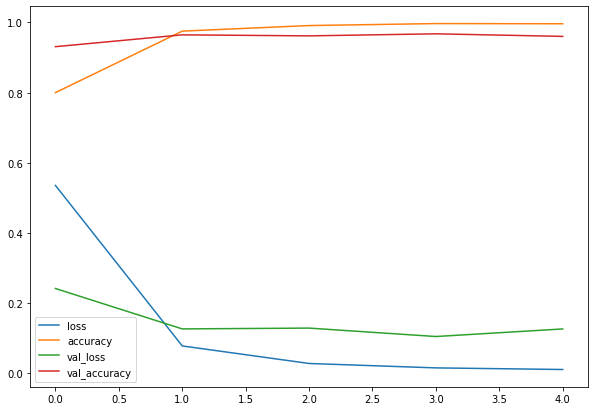

In [69]:
# Plot the training curves
import pandas as pd
pd.DataFrame(history0.history).plot(figsize=(10, 7));

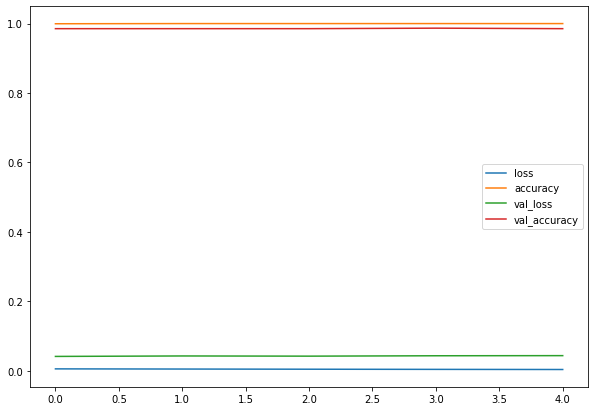

In [87]:

pd.DataFrame(history1.history).plot(figsize=(10, 7));

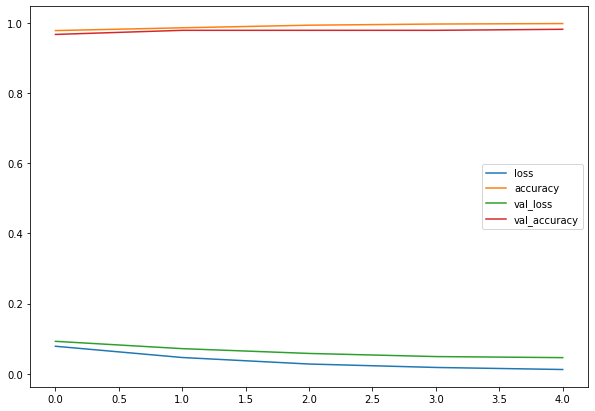

In [88]:
pd.DataFrame(history1ft.history).plot(figsize=(10, 7));

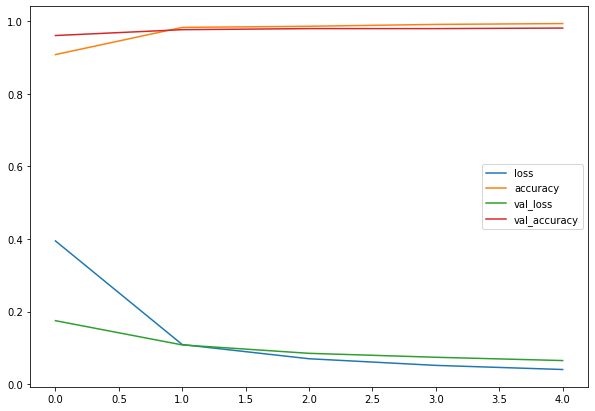

In [114]:
pd.DataFrame(history2.history).plot(figsize=(10, 7));

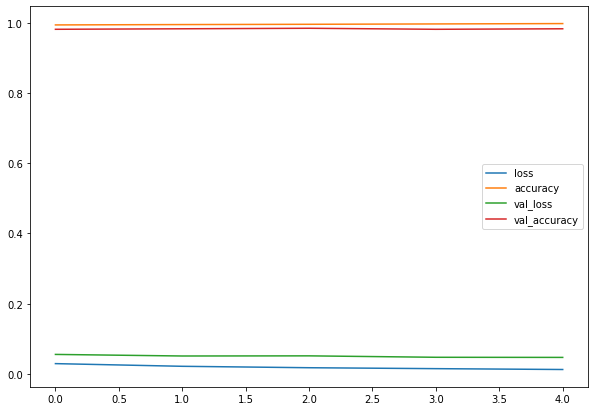

In [90]:
pd.DataFrame(history2ft.history).plot(figsize=(10, 7));

In [96]:
from tensorflow.keras.utils import plot_model

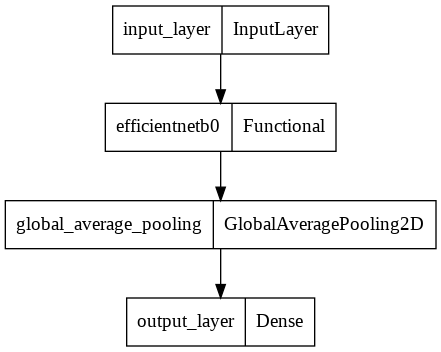

In [104]:
plot_model(model0,to_file="models/pic/m0.png")
plot_model(model1,to_file="models/pic/m1.png")
plot_model(model2,to_file="models/pic/m2.png")


In [115]:
import matplotlib.pyplot as plt

In [116]:
def plot_history_accuracy (history, model_name):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title(model_name+' accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show() 


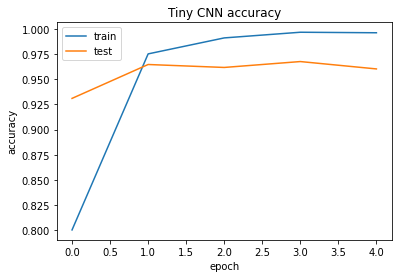

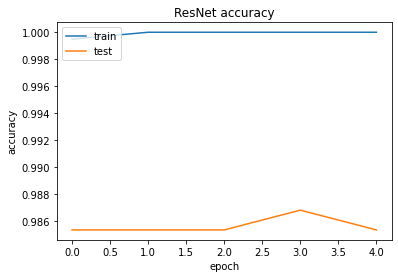

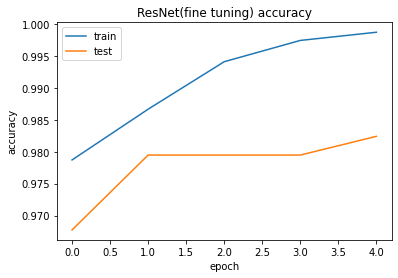

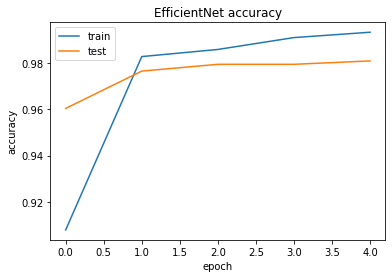

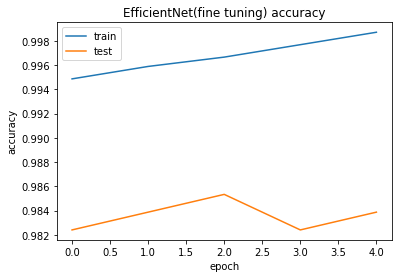

In [118]:
plot_history_accuracy(history0, "Tiny CNN")
plot_history_accuracy(history1, "ResNet")
plot_history_accuracy(history1ft, "ResNet(fine tuning)")
plot_history_accuracy(history2, "EfficientNet")
plot_history_accuracy(history2ft, "EfficientNet(fine tuning)")